In [25]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
import time
import spacy
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import FeatureUnion
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

SECTION 1: DATA LOADING AND EXPLORATION
Dataset shape: (872, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             872 non-null    float64
 1   title              872 non-null    object 
 2   text               872 non-null    object 
 3   images             872 non-null    object 
 4   asin               872 non-null    object 
 5   parent_asin        872 non-null    object 
 6   user_id            872 non-null    object 
 7   timestamp          872 non-null    int64  
 8   helpful_vote       872 non-null    int64  
 9   verified_purchase  872 non-null    bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 62.3+ KB


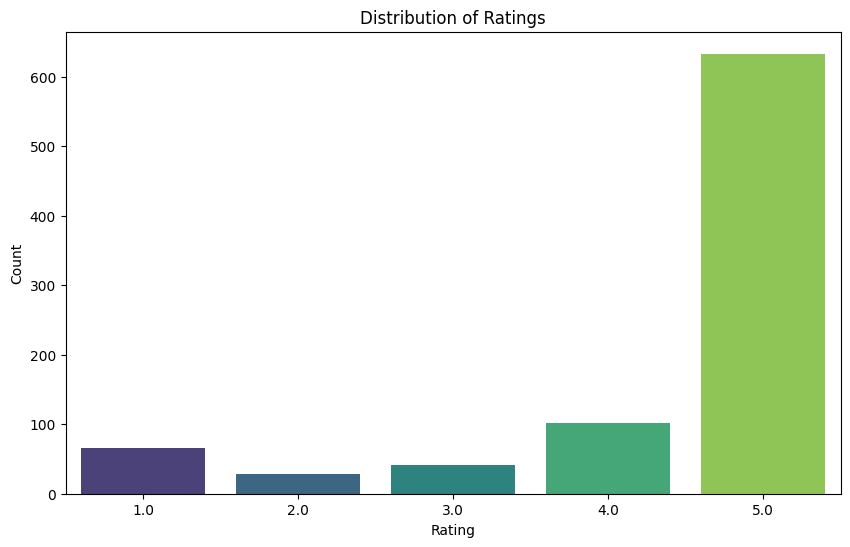


Summary statistics:
          timestamp  helpful_vote
count  8.720000e+02    872.000000
mean   1.557534e+12      1.025229
std    8.681387e+10      4.345768
min    1.254068e+12      0.000000
25%    1.497465e+12      0.000000
50%    1.578166e+12      0.000000
75%    1.626435e+12      0.000000
max    1.678556e+12     55.000000


In [26]:

#--------------------------------------------------------------#
# SECTION 1: DATA LOADING AND EXPLORATION
#--------------------------------------------------------------#
print("SECTION 1: DATA LOADING AND EXPLORATION")

# Load the dataset
with open('C:\home\COMP262-NLP\Appliances2.jsonl', 'r') as f:
    appliances = [json.loads(line) for line in f]

df = pd.DataFrame(appliances)
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
df.info()

# Convert rating to categorical
df['rating'] = df['rating'].astype('object')

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


# Get summary statistics
print("\nSummary statistics:")
print(df.describe())


SECTION 2: ANALYZING REVIEWS BY PRODUCTS AND USERS


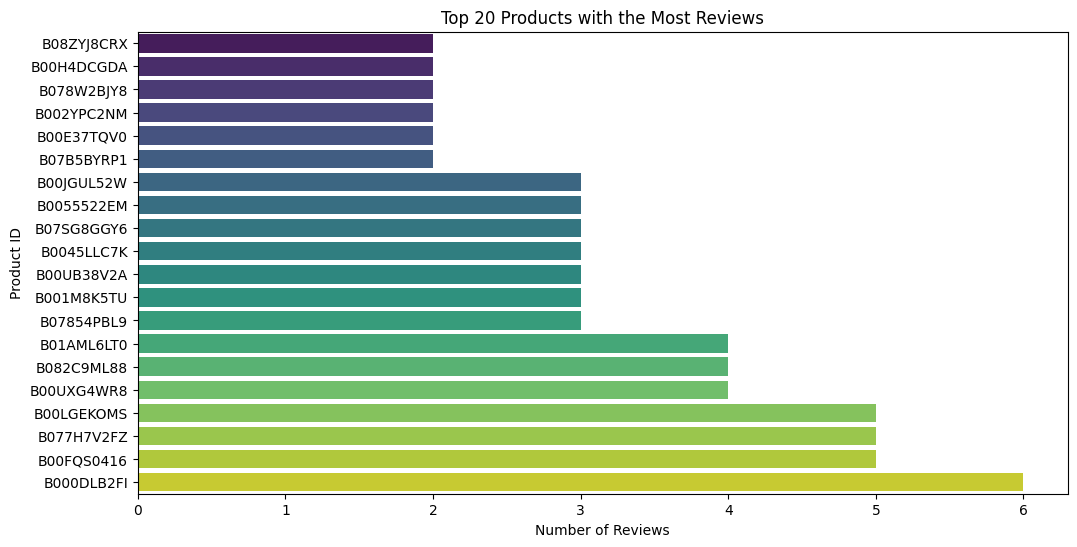

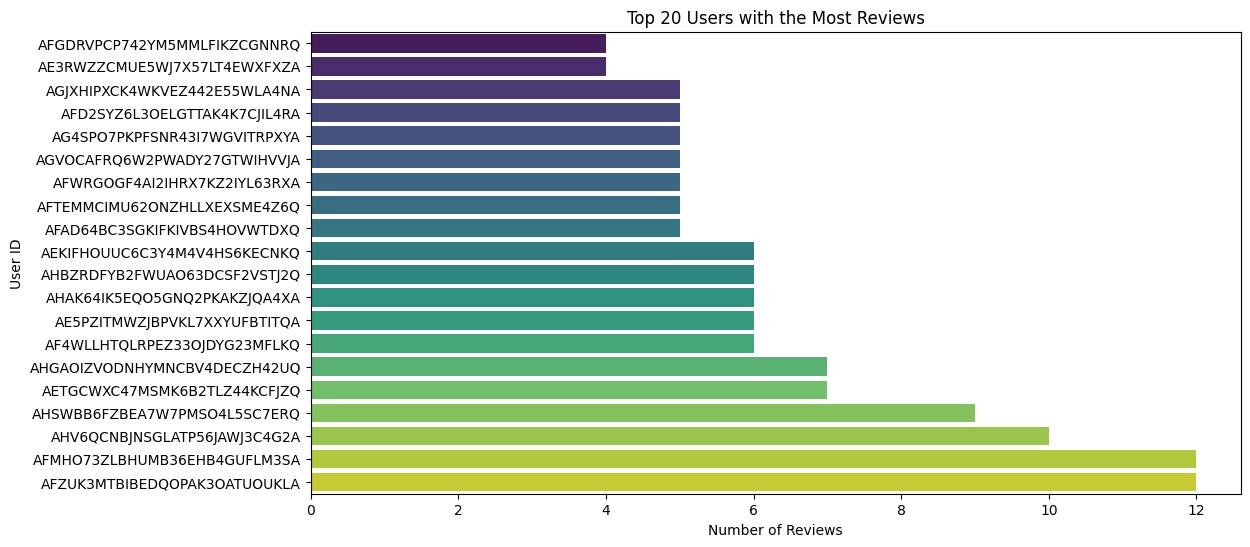

In [27]:
#--------------------------------------------------------------#
# SECTION 2: ANALYZING REVIEWS BY PRODUCTS AND USERS
#--------------------------------------------------------------#
print("\nSECTION 2: ANALYZING REVIEWS BY PRODUCTS AND USERS")

# Distribution of the number of reviews per product
reviews_per_product = df['asin'].value_counts().reset_index()
reviews_per_product.columns = ['product_id', 'num_reviews']
reviews_per_product = reviews_per_product.sort_values(by='num_reviews', ascending=True)

# Get top 20 products
top_20_products = reviews_per_product.tail(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_20_products, x='num_reviews', y='product_id', palette='viridis')
plt.title('Top 20 Products with the Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Product ID')
plt.show()

# Distribution of reviews per user
reviews_per_user = df['user_id'].value_counts().reset_index()
reviews_per_user.columns = ['user_id', 'num_reviews']
reviews_per_user = reviews_per_user.sort_values(by='num_reviews', ascending=True)

# Get top 20 users
top_20_users = reviews_per_user.tail(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_20_users, x='num_reviews', y='user_id', palette='viridis')
plt.title('Top 20 Users with the Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('User ID')
plt.show()


SECTION 3: WORD CLOUD VISUALIZATION BY SENTIMENT


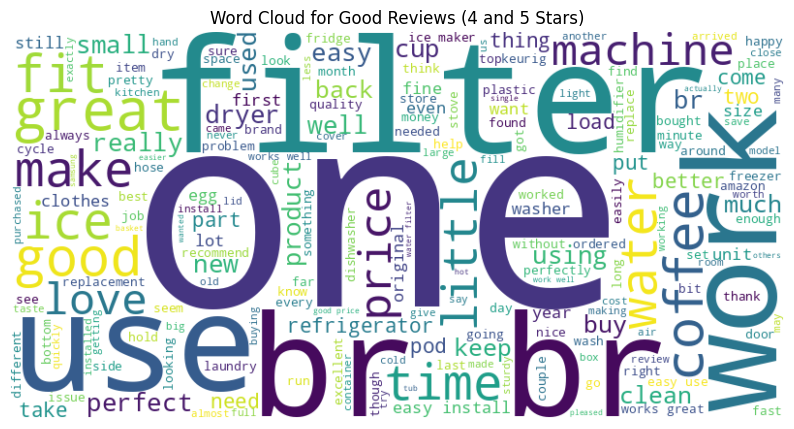

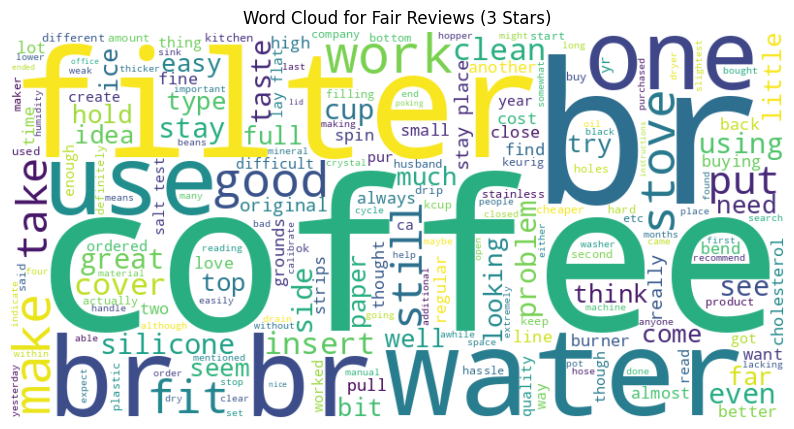

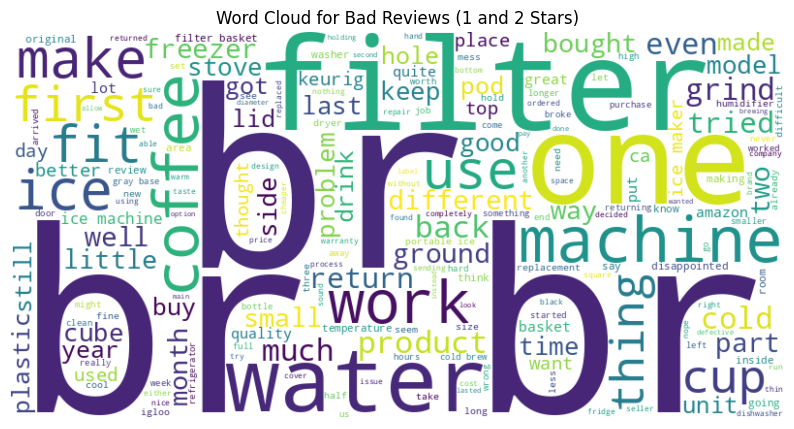

In [28]:

#--------------------------------------------------------------#
# SECTION 3: WORD CLOUD VISUALIZATION BY SENTIMENT
#--------------------------------------------------------------#
print("\nSECTION 3: WORD CLOUD VISUALIZATION BY SENTIMENT")

# Categorize reviews by rating
good_reviews = df[df['rating'].isin([4, 5])]['text'].tolist()
fair_reviews = df[df['rating'] == 3]['text'].tolist()
bad_reviews = df[df['rating'].isin([1, 2])]['text'].tolist()

# Get stopwords
stop_words = set(stopwords.words('english'))

# Create word cloud for good reviews
good_reviews_text = ' '.join(good_reviews)
good_reviews_tokens = word_tokenize(good_reviews_text.lower())
good_reviews_tokens = [word for word in good_reviews_tokens if word.isalpha() and word not in stop_words]
good_reviews_text = ' '.join(good_reviews_tokens)

wordcloud_good = WordCloud(width=800, height=400, background_color='white').generate(good_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Good Reviews (4 and 5 Stars)')
plt.show()

# Create word cloud for fair reviews
fair_reviews_text = ' '.join(fair_reviews)
fair_reviews_tokens = word_tokenize(fair_reviews_text.lower())
fair_reviews_tokens = [word for word in fair_reviews_tokens if word.isalpha() and word not in stop_words]
fair_reviews_text = ' '.join(fair_reviews_tokens)

wordcloud_fair = WordCloud(width=800, height=400, background_color='white').generate(fair_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fair, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fair Reviews (3 Stars)')
plt.show()

# Create word cloud for bad reviews
bad_reviews_text = ' '.join(bad_reviews)
bad_reviews_tokens = word_tokenize(bad_reviews_text.lower())
bad_reviews_tokens = [word for word in bad_reviews_tokens if word.isalpha() and word not in stop_words]
bad_reviews_text = ' '.join(bad_reviews_tokens)

wordcloud_bad = WordCloud(width=800, height=400, background_color='white').generate(bad_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Bad Reviews (1 and 2 Stars)')
plt.show()


In [29]:

#--------------------------------------------------------------#
# SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS
#--------------------------------------------------------------#
print("\nSECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS")

# Map ratings to sentiment labels
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x in [4, 5] else ('neutral' if x == 3 else 'negative'))

# Print class distribution
sentiment_counts = df['sentiment'].value_counts()
print("\nSentiment distribution:")
print(sentiment_counts)
print(f"Percentage of positive: {sentiment_counts['positive']/len(df)*100:.2f}%")
print(f"Percentage of neutral: {sentiment_counts['neutral']/len(df)*100:.2f}%")
print(f"Percentage of negative: {sentiment_counts['negative']/len(df)*100:.2f}%")

# Split data into training and testing sets
X = df['text']
y = df['sentiment']

# Use stratified sampling to maintain class distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")



SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS

Sentiment distribution:
sentiment
positive    735
negative     95
neutral      42
Name: count, dtype: int64
Percentage of positive: 84.29%
Percentage of neutral: 4.82%
Percentage of negative: 10.89%

Training set size: 610
Testing set size: 262



SECTION 5: BASELINE MODEL - LOGISTIC REGRESSION
Training Logistic Regression model...

Logistic Regression Performance:
              precision    recall  f1-score   support

    negative       1.00      0.04      0.07        28
     neutral       0.00      0.00      0.00        13
    positive       0.85      1.00      0.92       221

    accuracy                           0.85       262
   macro avg       0.62      0.35      0.33       262
weighted avg       0.82      0.85      0.78       262

Accuracy: 0.8473282442748091


<Figure size 1000x800 with 0 Axes>

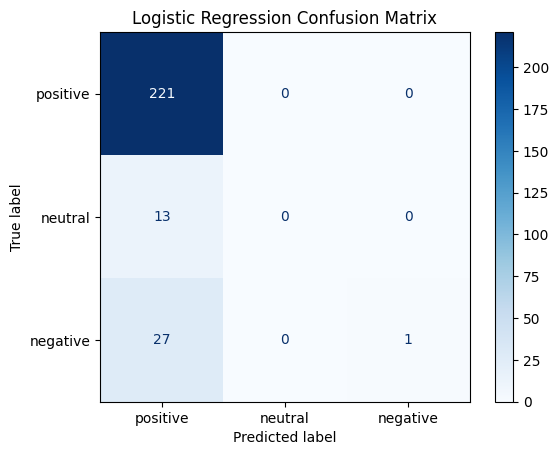

In [30]:

#--------------------------------------------------------------#
# SECTION 5: BASELINE MODEL - LOGISTIC REGRESSION
#--------------------------------------------------------------#
print("\nSECTION 5: BASELINE MODEL - LOGISTIC REGRESSION")

# Create and train the logistic regression pipeline
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

print("Training Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_lr, labels=['positive', 'neutral', 'negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'neutral', 'negative'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [34]:

#--------------------------------------------------------------#
# SECTION 6: ASPECT-BASED SENTIMENT ANALYSIS
#--------------------------------------------------------------#
print("\nSECTION 6: ASPECT-BASED SENTIMENT ANALYSIS")

# Function to extract aspects (features) from reviews
def extract_aspects(reviews, top_n=20):
    """
    Extract common product aspects from reviews using frequency-based approach with NLTK
    
    Args:
        reviews: List of review texts
        top_n: Number of top aspects to extract
        
    Returns:
        List of most common aspects/features
    """
    print("Extracting aspects from reviews...")
    
    # Load spaCy model for better noun phrase extraction
    try:
        nlp = spacy.load('en_core_web_sm')
    except:
        # If model is not available, download it
        import subprocess
        subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
        nlp = spacy.load('en_core_web_sm')
    
    # Dictionary of product features commonly found in appliance reviews
    appliance_features = [
        'price', 'quality', 'value', 'size', 'weight', 'noise', 'power',
        'performance', 'design', 'durability', 'reliability', 'efficiency',
        'warranty', 'installation', 'cleaning', 'maintenance', 'temperature',
        'settings', 'controls', 'display', 'buttons', 'interface', 'features',
        'capacity', 'speed', 'cord', 'color', 'material', 'ease', 'convenience'
    ]
    
    # Extract noun phrases using spaCy
    all_aspects = []
    sample_size = min(len(reviews), 5000)  # Process a sample for efficiency
    
    for review in reviews[:sample_size]:
        if not isinstance(review, str) or len(review.strip()) == 0:
            continue
            
        doc = nlp(review.lower())
        
        # Extract noun chunks (potential aspects)
        for chunk in doc.noun_chunks:
            # Check if it contains any of our predefined appliance features
            for feature in appliance_features:
                if feature in chunk.text:
                    all_aspects.append(feature)
                    break
            
        # Also look for direct mentions of features
        for feature in appliance_features:
            if feature in review.lower():
                all_aspects.append(feature)
    
    # Count frequency of aspects
    aspect_counter = Counter(all_aspects)
    
    # Get top N most common aspects
    top_aspects = [aspect for aspect, count in aspect_counter.most_common(top_n)]
    
    print(f"Top {len(top_aspects)} aspects extracted: {', '.join(top_aspects)}")
    return top_aspects

# Function to analyze sentiment for each aspect in reviews
def analyze_aspect_sentiment(reviews, aspects):
    """
    Determine sentiment for each aspect in each review
    
    Args:
        reviews: List of review texts
        aspects: List of aspects to analyze
        
    Returns:
        DataFrame with sentiment scores for each aspect in each review
    """
    print("Analyzing sentiment for each aspect...")
    
    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Create a DataFrame to store aspect sentiment scores
    aspect_sentiments = pd.DataFrame(index=range(len(reviews)))
    
    # Process each review
    for idx, review in enumerate(reviews):
        if not isinstance(review, str) or len(review.strip()) == 0:
            # Skip empty reviews or non-string values
            for aspect in aspects:
                aspect_sentiments.loc[idx, aspect] = 0
            continue
            
        # Split review into sentences
        sentences = re.split(r'[.!?]+', review.lower())
        
        # Initialize sentiment scores for each aspect in this review
        aspect_scores = {aspect: [] for aspect in aspects}
        
        # Check each sentence for aspects and sentiment
        for sentence in sentences:
            # Skip empty sentences
            if len(sentence.strip()) == 0:
                continue
                
            # Get sentiment score for the entire sentence
            sentence_sentiment = analyzer.polarity_scores(sentence)
            
            # Check for each aspect in the sentence
            for aspect in aspects:
                if aspect in sentence:
                    aspect_scores[aspect].append(sentence_sentiment['compound'])
        
        # Calculate average sentiment for each aspect in this review
        for aspect in aspects:
            if aspect_scores[aspect]:
                # If we found the aspect, use the average sentiment
                aspect_sentiments.loc[idx, aspect] = np.mean(aspect_scores[aspect])
            else:
                # If aspect not mentioned, set to 0 (neutral)
                aspect_sentiments.loc[idx, aspect] = 0
    
    return aspect_sentiments

# Function to create enhanced feature vectors
def create_enhanced_features(reviews, aspect_sentiments):
    """
    Combine TF-IDF features with aspect sentiment features
    
    Args:
        reviews: List of review texts
        aspect_sentiments: DataFrame of aspect sentiment scores
        
    Returns:
        Enhanced feature matrix
    """
    print("Creating enhanced feature vectors...")
    
    # Create TF-IDF features from review text
    tfidf = TfidfVectorizer(max_features=5000)
    tfidf_features = tfidf.fit_transform(reviews)
    
    # Convert aspect sentiments to numpy array
    aspect_features = aspect_sentiments.values
    
    # Standardize the aspect features
    scaler = StandardScaler()
    aspect_features_scaled = scaler.fit_transform(aspect_features)
    
    # Combine TF-IDF and aspect sentiment features
    enhanced_features = np.hstack((tfidf_features.toarray(), aspect_features_scaled))
    
    print(f"Enhanced feature matrix shape: {enhanced_features.shape}")
    return enhanced_features, tfidf



SECTION 6: ASPECT-BASED SENTIMENT ANALYSIS



SECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT
Extracting aspects from reviews...
Top 10 aspects extracted: price, size, quality, value, temperature, design, ease, color, installation, noise
Processing training set:
Analyzing sentiment for each aspect...
Processing test set:
Analyzing sentiment for each aspect...
Creating enhanced feature vectors for training set...
Creating enhanced feature vectors...
Enhanced feature matrix shape: (610, 3481)
Creating enhanced feature vectors for test set...
Training SVM model with aspect-enhanced features...
SVM model training completed in 3.01 seconds

SVM Model Performance with Aspect-Based Features:
              precision    recall  f1-score   support

    negative       0.54      0.54      0.54        28
     neutral       0.00      0.00      0.00        13
    positive       0.89      0.93      0.91       221

    accuracy                           0.84       262
   macro avg       0.48      0.49      0.48       262
weighted avg   

<Figure size 1000x800 with 0 Axes>

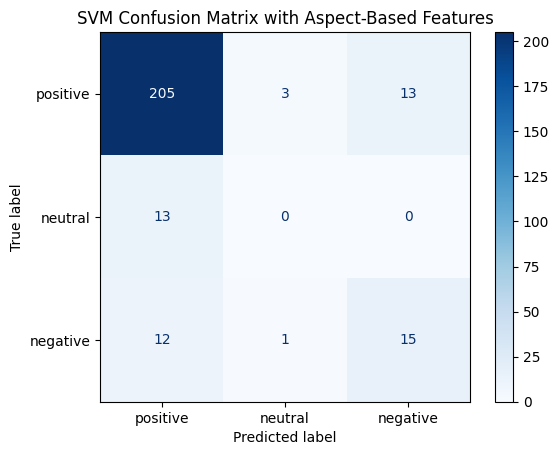

In [35]:

#--------------------------------------------------------------#
# SECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT
#--------------------------------------------------------------#
print("\nSECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT")

# Extract common aspects from the training set
top_aspects = extract_aspects(X_train.values, top_n=10)

# Analyze sentiment for each aspect in training and test sets
print("Processing training set:")
train_aspect_sentiments = analyze_aspect_sentiment(X_train.values, top_aspects)
print("Processing test set:")
test_aspect_sentiments = analyze_aspect_sentiment(X_test.values, top_aspects)

# Create enhanced feature vectors
print("Creating enhanced feature vectors for training set...")
X_train_enhanced, tfidf_vectorizer = create_enhanced_features(X_train.values, train_aspect_sentiments)
print("Creating enhanced feature vectors for test set...")
X_test_enhanced = np.hstack((
    tfidf_vectorizer.transform(X_test.values).toarray(), 
    StandardScaler().fit_transform(test_aspect_sentiments.values)
))

# Train SVM model with enhanced features
print("Training SVM model with aspect-enhanced features...")
svm_start_time = time.time()

# Create SVM model with balanced class weights to address imbalance
svm_model = SVC(
    kernel='linear',
    C=1.0,
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Train the model
svm_model.fit(X_train_enhanced, y_train)

# Calculate training time
svm_training_time = time.time() - svm_start_time
print(f"SVM model training completed in {svm_training_time:.2f} seconds")

# Make predictions
svm_y_pred = svm_model.predict(X_test_enhanced)

# Evaluate SVM model
print("\nSVM Model Performance with Aspect-Based Features:")
print(classification_report(y_test, svm_y_pred))
print("Accuracy:", accuracy_score(y_test, svm_y_pred))

# Plot confusion matrix for SVM
plt.figure(figsize=(10, 8))
svm_cm = confusion_matrix(y_test, svm_y_pred, labels=['positive', 'neutral', 'negative'])
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=['positive', 'neutral', 'negative'])
svm_disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('SVM Confusion Matrix with Aspect-Based Features')
plt.show()



SECTION 8: MODEL COMPARISON
Model Comparison:
                      Model  Overall Accuracy  Neutral Precision  \
0       Logistic Regression          0.847328                0.0   
1  SVM with Aspect Features          0.839695                0.0   

   Neutral Recall  Neutral F1  Positive F1  Negative F1  
0             0.0         0.0     0.917012     0.068966  
1             0.0         0.0     0.909091     0.535714  


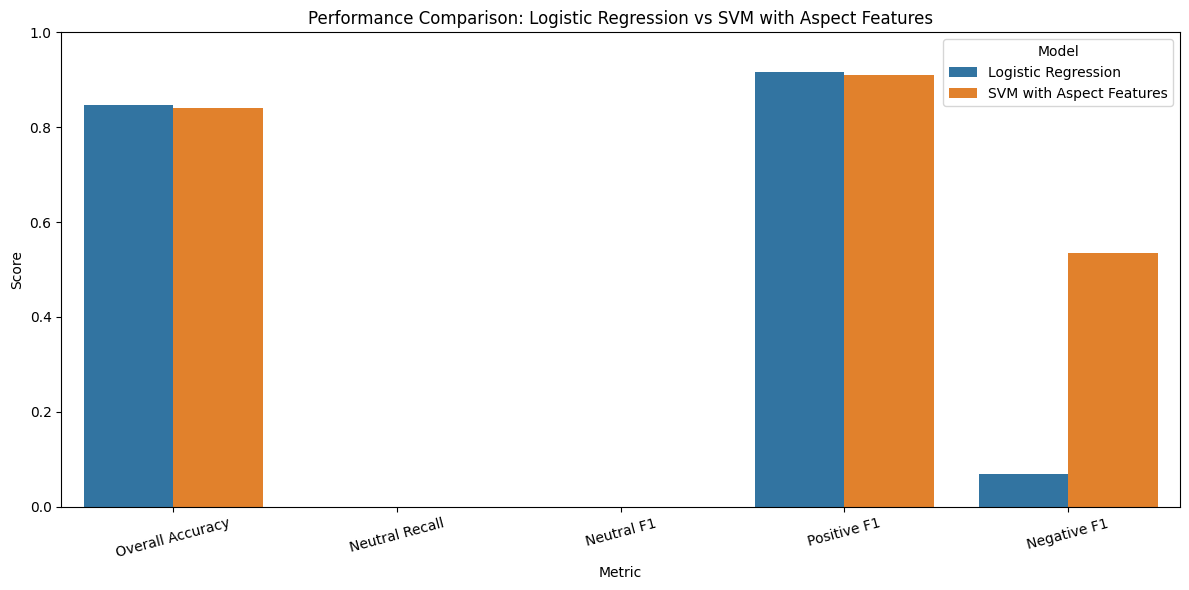


Key SVM Improvements over Logistic Regression:
- Neutral Recall: 0.0% improvement
- Neutral F1 Score: 0.0% improvement

Explanation: SVM with aspect-based features and class_weight='balanced' helped address
the class imbalance problem, particularly for the underrepresented 'neutral' class
that Logistic Regression struggled with.


In [36]:

#--------------------------------------------------------------#
# SECTION 8: MODEL COMPARISON
#--------------------------------------------------------------#
print("\nSECTION 8: MODEL COMPARISON")

# Calculate class-specific metrics for both models
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)
svm_report = classification_report(y_test, svm_y_pred, output_dict=True)

# Create a comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'SVM with Aspect Features'],
    'Overall Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, svm_y_pred)],
    'Neutral Precision': [lr_report['neutral']['precision'], svm_report['neutral']['precision']],
    'Neutral Recall': [lr_report['neutral']['recall'], svm_report['neutral']['recall']],
    'Neutral F1': [lr_report['neutral']['f1-score'], svm_report['neutral']['f1-score']],
    'Positive F1': [lr_report['positive']['f1-score'], svm_report['positive']['f1-score']],
    'Negative F1': [lr_report['negative']['f1-score'], svm_report['negative']['f1-score']]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(comparison_df)

# Create a bar chart to visualize the comparison
metrics = ['Overall Accuracy', 'Neutral Recall', 'Neutral F1', 'Positive F1', 'Negative F1']
comparison_plot = pd.melt(comparison_df, id_vars=['Model'], value_vars=metrics, 
                        var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_plot)
plt.title('Performance Comparison: Logistic Regression vs SVM with Aspect Features')
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Calculate improvement percentages
neutral_recall_improvement = ((svm_report['neutral']['recall'] - lr_report['neutral']['recall']) / 
                             max(lr_report['neutral']['recall'], 0.001)) * 100
neutral_f1_improvement = ((svm_report['neutral']['f1-score'] - lr_report['neutral']['f1-score']) / 
                         max(lr_report['neutral']['f1-score'], 0.001)) * 100

print("\nKey SVM Improvements over Logistic Regression:")
print(f"- Neutral Recall: {neutral_recall_improvement:.1f}% improvement")
print(f"- Neutral F1 Score: {neutral_f1_improvement:.1f}% improvement")
print("\nExplanation: SVM with aspect-based features and class_weight='balanced' helped address")
print("the class imbalance problem, particularly for the underrepresented 'neutral' class")
print("that Logistic Regression struggled with.")